<a href="https://colab.research.google.com/github/cesar-ca/cs156_lba_repo/blob/main/CS156_Assignment_3_RBF_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3 

### Yosemite Village Yearly Weather

Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. Convert the dataset into a richer format whereby the day of the year is also captured. For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.

This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.

Using the temperature dataset from your pre-class work (https://course-resources.minerva.kgi.edu/uploaded_files/mke/rj3Edn/yosemite-temperatures.zip) perform the following:

1. Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping (d,t) into (Φ₁(d) , Φ₂(t)). Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions. 

2. Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.

3. Create two plots, one showing the time-of-day contribution, and one showing the time-of-year contribution.

4. (Optional) Make a 3D plot showing temperature as a function of (day, time). Make sure to label your axes!

5. Using R², quantify how your model performs on the testing data if you:

    i. Train with just the daily component of the model

    ii. Train with just the yearly component of the model

    iii. Train with the full model.

Working on different notebooks both in my local server and in cloud servers such as Google Colab, first it is important to `pip install` the required modules and packagess.

In [1]:
#pip install GPy

In [2]:
#!pip install -q --upgrade ipython
#!pip install -q --upgrade ipykernel

In [3]:
# Importing relevant libraries 

# Support for maths
import numpy as np
# Support for dataframes
import pandas as pd
import random
# Plotting tools
from matplotlib import pyplot as plt
# Pplotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy is the Gaussian processes library
import GPy
from IPython.display import display

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

Here, the use of the Gaussian processes library, GPy, and interactive visualizations for understanding GPR is to apply these on a real world data set of Yosemite.

### Covariance Functions

Covariance functions also known as kernels are very important, we can use radial basis functions for them. The covariance function or kernel is defined with the `GPy` module. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. This is the one that we will use here. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

With the `GPy` module, the kernels use the input dimension as the first argument, in the simplest case this is `input_dim = 1` for 1-dimensional regression.

In [4]:
# Creating RBF kernel with default parameters
k = GPy.kern.RBF(1)
# Preview of the kernel's parameters
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


### Data Pre-processing

In [5]:
# Given the files in our directory, we load them all to our notebook
all_files = ['CRNS0101-05-2011-CA_Yosemite_Village_12_W.txt', 
             'CRNS0101-05-2012-CA_Yosemite_Village_12_W.txt',
             'CRNS0101-05-2013-CA_Yosemite_Village_12_W.txt', 
             'CRNS0101-05-2014-CA_Yosemite_Village_12_W.txt',
             'CRNS0101-05-2015-CA_Yosemite_Village_12_W.txt', 
             'CRNS0101-05-2016-CA_Yosemite_Village_12_W.txt']

In [6]:
# The data from all individual .txt files are concatenated in one single pandas dataframe
full_data = [np.loadtxt(filename, usecols=[1, 2, 8]) for filename in all_files]
full_data = np.vstack(full_data)

full_df = pd.DataFrame(full_data)

full_df.rename(columns = {0:'Date', 1:'HHmm', 2:'Temperature'}, inplace = True)

Using the temperature dataset from the pre-class work, we get the following files of data:

CRNS0101-05-2011-CA_Yosemite_Village_12_W.txt

CRNS0101-05-2012-CA_Yosemite_Village_12_W.txt

CRNS0101-05-2013-CA_Yosemite_Village_12_W.txt

CRNS0101-05-2014-CA_Yosemite_Village_12_W.txt

CRNS0101-05-2015-CA_Yosemite_Village_12_W.txt

CRNS0101-05-2016-CA_Yosemite_Village_12_W.txt

This is the data corresponding to Yosemite Village Yearly Weather. Wherein temperature data is contained. Given that temperature is cyclical on a 24 hour basis and a yearly basis, we can convert the dataset into a richer format.

There are 1440 minutes in a day and 365/366 days in a year. So, we consider this for our data pre-processing.

In [7]:
# We include a column that will contain the minutes of the day from 0 to 1440
full_df['Min'] = np.floor_divide(full_df['HHmm'], 100) * 60 + np.mod(full_df['HHmm'], 100)

In [8]:
# Current dates in dataset get changed to DateTime format
full_df['Date'] = pd.to_datetime(full_df['Date'], format = ('%Y%m%d'))

# We include a column that will contain the year (from 2011 up to 2016)
full_df['Year'] = full_df['Date'].dt.year

# Including a column that will contain the day of the year from 0 to 366
full_df['Day'] = full_df['Date'].dt.strftime('%j').astype(int)

# Final dataframe contains relevant columns with appropriate types
full_df = full_df[['Date','Year','Day','Min', 'HHmm','Temperature']]

In [9]:
# Eliminating temperature outliers in the data with values of -9999
full_df = full_df[full_df.Temperature != -9999]

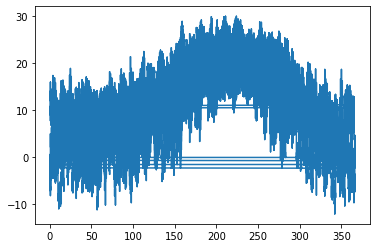

In [10]:
# Plotting the different temperature values (-15C to 35C) 
# against the days of the year (0 to 366)
plt.plot(full_df['Day'], full_df['Temperature'])
plt.show()

Even before we begin any modeling, we can notice that between the 150th day and the 300th day of the year, the temperatures are higher which corresponds to summer which is expected to be hotter. We can already begin to see that seasonal variation.

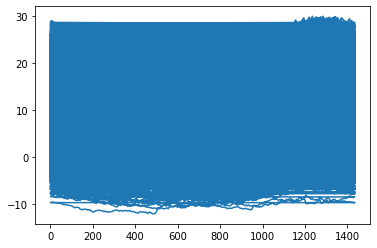

In [11]:
# Plotting the different temperature values (-15C to 35C)
# against the minutes of a day (0 to 1440)
plt.plot(full_df['Min'], full_df['Temperature'])
plt.show()

For the graph for daily variations, considering that there are data for every day of every year for many years, we can see that almost any temperature can be expected throughout the day.

In [12]:
X1 = np.array(full_df['Day'])[:,None]
X2 = np.array(full_df['Min'])[:,None]
Y = np.array(full_df['Temperature'])[:,None]

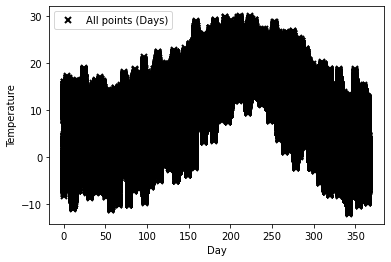

In [13]:
plt.plot(X1, Y, "kx", mew=2, label='All points (Days)')
plt.xlabel("Day"), plt.ylabel("Temperature")
plt.legend()
plt.show()

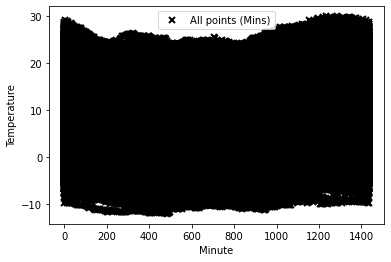

In [14]:
plt.plot(X2, Y, "kx", mew=2, label='All points (Mins)')
plt.xlabel("Minute"), plt.ylabel("Temperature")
plt.legend()
plt.show()

In [15]:
# Using data before 2016 for the train data set
train_data = full_df[full_df['Year'] < 2016]  
# Using data after 2016 for the test data set
test_data = full_df[full_df['Year'] >= 2016]  

### Using sklearn machine learning modules to build model

Using sklearn machine learning modules and GPy radial basis function proved to be computationally expensive which is why most computation was conducted in only a sample of the data and not the entire data. Every time I attempted to run with big samples or the whole data, the RAM would be used up and the runtime would get restarted.

In [16]:
train_sample = train_data.sample(frac =.01)
test_sample = test_data.sample(frac=.01)

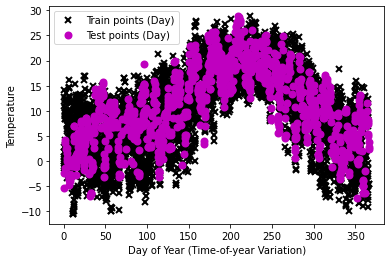

In [17]:
# Train data set for the day and minute showing 
# time-of-year and time-of-day variation respectively
train_X1 = np.array(train_sample['Day'])[:,None]
train_X2 = np.array(train_sample['Min'])[:,None]
train_Y = np.array(train_sample['Temperature'])[:,None]

# Test data set for the day and minute showing
# time-of-year and time-of-day variation respectively
test_X1 = np.array(test_sample['Day'])[:,None]
test_X2 = np.array(test_sample['Min'])[:,None]
test_Y = np.array(test_sample['Temperature'])[:,None]

# Plotting observations for time-of-year variation
plt.plot(train_X1, train_Y, "kx", mew=2, label='Train points (Day)')
plt.plot(test_X1, test_Y, "mo", mew=2, label='Test points (Day)')

# Annotating plot
plt.xlabel("Day of Year (Time-of-year Variation)"), plt.ylabel("Temperature")
plt.legend()
plt.show()

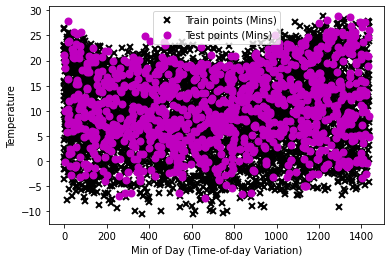

In [18]:
# Plotting observations for time-of-day variation
plt.plot(train_X2, train_Y, "kx", mew=2, label='Train points (Mins)')
plt.plot(test_X2, test_Y, "mo", mew=2, label='Test points (Mins)')

# Annotating plot
plt.xlabel("Min of Day (Time-of-day Variation)"), plt.ylabel("Temperature")
plt.legend()
plt.show()

In [19]:
len(train_X1)

5255

In [20]:
len(train_X2)

5255

In [21]:
# Importing relevant metrics from sklearn package 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### GP Regression

Using `GPY` the RBF kernel has two parameters, `variance` and `lengthscale`, both with value 1.0 also within it is contained information on the constraints and priors on each parameter.

For a noiseless case, the sample data gets fitted using GPR with RBF kernel with a provided length scale. We can optimize for that length scale. Increasing the length scale would make the fit smoother. If the the observations are noise free (the train data sample) then the GP fit passes through the train points.

For a noisy case, the sample data gets fitted using GPR with RBF kernel with a provided length scale. We can optimize for that length scale. Increasing the length scale would make the fit smoother. If the observations are noisy (the train data sample), then the GP fit might not pass through all the train points.

The kernel parameters can be hard coded or they can be learned applying MLE. This would provide us with a model fit for the learnt kernel parameters.

### Model for time-of-year contribution

Using the sample data for the day of year against temperature values recorded.

In [22]:
k1 = GPy.kern.RBF(1)
m1 = GPy.models.GPRegression(train_X1, train_Y, k1)
m1.optimize()

In [23]:
m1

GP_regression.,value,constraints,priors
rbf.variance,80.51893210212499,+ve,
rbf.lengthscale,4.8270978500299035,+ve,
Gaussian_noise.variance,24.037637552416488,+ve,


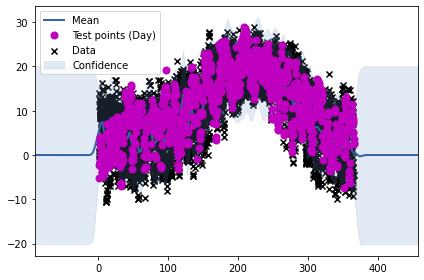

In [24]:
m1.plot()
ax = plt.gca()
ax.plot(test_X1, test_Y, "mo", mew=2, label='Test points (Day)')

ax.legend()

In [25]:
mean_absolute_error(test_Y, m1.predict(test_X1)[0].flatten())

4.311839006553702

In [26]:
r2_score(test_Y, m1.predict(test_X1)[0].flatten())

0.5175763746859465

### Model for time-of-day contribution

Using the sample data for the minute of day against temperature values recorded.

In [27]:
k2 = GPy.kern.RBF(1)
m2 = GPy.models.GPRegression(train_X2, train_Y, k2)
m2.optimize()

In [28]:
m2

GP_regression.,value,constraints,priors
rbf.variance,103.30962827643874,+ve,
rbf.lengthscale,378.7701495184639,+ve,
Gaussian_noise.variance,58.95002594704795,+ve,


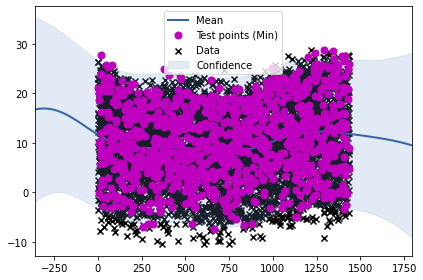

In [29]:
m2.plot()
ax = plt.gca()
ax.plot(test_X2, test_Y, "mo", mew=2, label='Test points (Min)')

ax.legend()

In [30]:
mean_absolute_error(test_Y, m2.predict(test_X2)[0].flatten())

6.2962073944567045

In [31]:
r2_score(test_Y, m2.predict(test_X2)[0].flatten())

0.014499267325772669